In [97]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime, timedelta
from collections import defaultdict

In [98]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define parameters
num_rows = 50000
max_interactions_per_user = 10

# Generate random number of unique user IDs (ensure it's less than num_rows)
num_unique_users = num_rows // max_interactions_per_user
user_ids = [f"user_{i}" for i in range(1, num_unique_users + 1)]

# Define event names for user journey
event_names = [
    "Homepage Visit",
    "Product View",
    "Product Details View",
    "Add to Cart",
    "Checkout",
    "Purchase"
]

# Create the dataset
data = []
for user_id in user_ids:
    # Random number of interactions per user (minimum 1, maximum 10)
    num_interactions = random.randint(1, max_interactions_per_user)
    start_time = datetime.now() - timedelta(days=30)  # Start timestamp 30 days ago

    for i in range(num_interactions):
        # Event names should build towards "Purchase"
        event_name = event_names[min(i, len(event_names) - 1)]

        # Append row to the dataset
        data.append({
            "user_id": user_id,
            "event": i + 1,
            "event_timestamp": start_time + timedelta(minutes=i * random.randint(1, 60)),
            "event_name": event_name
        })

        # Stop at "Purchase" to ensure sequential logic
        if event_name == "Purchase":
            break

# Convert to DataFrame
df = pd.DataFrame(data)

# Shuffle the rows to mimic realistic, non-ordered data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# # Calculate the number of users who should have made a purchase
# num_purchasers = int(0.026 * len(user_ids))

# # Select 5% of the users randomly to have made a purchase
# purchasers = set(random.sample(user_ids, num_purchasers))

# # Update the dataset to ensure only these users have the "Purchase" event
# filtered_data = []
# for _, row in df.iterrows():
#     if row["event_name"] == "Purchase":
#         if row["user_id"] in purchasers:
#             filtered_data.append(row)
#     else:
#         filtered_data.append(row)

# # Create a new DataFrame from the filtered data
# df_filtered = pd.DataFrame(filtered_data)

# # Ensure data consistency by resetting indices
# df_filtered = df_filtered.reset_index(drop=True)

# # Validate the result
# purchase_count = df_filtered[df_filtered["event_name"] == "Purchase"]["user_id"].nunique()
# total_users = df_filtered["user_id"].nunique()

# df_filtered.head(), purchase_count, total_users, (purchase_count / total_users) * 100

In [99]:
#Import dataset
# journey = pd.read_csv('/Users/chelseavalencia/Desktop/prospect_user_journey_dataset.csv')

journey = df

In [100]:
#Create new column indicating if prospect purchased product
# journey['purchase'] = np.where(journey['event_name'] == 'Checkout', 1, 0)

#Create flag if user completed purchase
journey['purchased'] = journey.groupby('user_id')['event_name'].transform(lambda events: 1 if 'Purchase' in events.values else 0)

In [101]:
#Select small sample to test code
journey_small = journey.sort_values(by='user_id').head(20)

In [102]:
#Sort values by user_id and event timestamp to create sequential order
data_sorted = journey.sort_values(by=['user_id', 'event_timestamp'])

#Group events by the user_id and event_name and convert to list format
grouped = data_sorted.groupby('user_id')['event_name'].apply(list)

In [103]:
#View grouped dataframe
grouped.head()

user_id
user_1                                                              [Homepage Visit, Product View]
user_10                                                             [Homepage Visit, Product View]
user_100               [Homepage Visit, Product View, Product Details View, Add to Cart, Checkout]
user_1000    [Homepage Visit, Product View, Add to Cart, Product Details View, Purchase, Checkout]
user_1001    [Homepage Visit, Add to Cart, Product Details View, Product View, Checkout, Purchase]
Name: event_name, dtype: object

In [104]:
#Convert the Series into a dataframe in order to add a new column
grouped = pd.DataFrame(grouped)

#Identify users that made a purchase
conversion = data_sorted[['user_id', 'purchased']].drop_duplicates(keep = 'first')

#Merge grouped dataset with purchase dataset 
grouped = pd.merge(grouped, conversion, on='user_id', how ='left')

In [105]:
grouped.head()

,user_id,event_name,purchased
0,user_1,"[Homepage Visit, Product View]",0
1,user_10,"[Homepage Visit, Product View]",0
2,user_100,"[Homepage Visit, Product View, Product Details View, Add to Cart, Checkout]",0
3,user_1000,"[Homepage Visit, Product View, Add to Cart, Product Details View, Purchase, Checkout]",1
4,user_1001,"[Homepage Visit, Add to Cart, Product Details View, Product View, Checkout, Purchase]",1


In [106]:
#Create purchase paths
#Each path has a beginning point and either ends in a purchase or no purchase
grouped['path'] = np.where(
    grouped['purchased'] == 0, 
    ['Start, '] + grouped['event_name'].apply(', '.join) + [', No Purchase'],
    ['Start, '] + grouped['event_name'].apply(', '.join) + [', Purchase'])

#Split the column contents based on delimited identifier
grouped['path'] = grouped['path'].str.split(', ')

In [107]:
#QA paths output
pd.set_option('display.max_colwidth', 200)
grouped.path

0                                                           [Start, Homepage Visit, Product View, No Purchase]
1                                                           [Start, Homepage Visit, Product View, No Purchase]
2              [Start, Homepage Visit, Product View, Product Details View, Add to Cart, Checkout, No Purchase]
3       [Start, Homepage Visit, Product View, Add to Cart, Product Details View, Purchase, Checkout, Purchase]
4       [Start, Homepage Visit, Add to Cart, Product Details View, Product View, Checkout, Purchase, Purchase]
                                                         ...                                                  
4995                                                                      [Start, Homepage Visit, No Purchase]
4996                                  [Start, Homepage Visit, Product View, Product Details View, No Purchase]
4997                                                                      [Start, Homepage Visit, No Purchase]
4

In [108]:
#Initialize nested dictionary to store transition counts 
#The outer dictionary holds the current state, and the inner dictionary maps to the counts of next states
transition_counts = defaultdict(lambda: defaultdict(int))

#Iterate through each sequence in the 'path' column of the grouped dataset
for sequence in grouped.path:
    #Loop through each state in the state in the sequence, up to the last state 
    for i in range(len(sequence) - 1):
        #Identify the current state in the sequence
        current_state = sequence[i]
        #Identify next state immediately following the current state
        next_state = sequence[i+1]
        #Count of transitions from current state to next state
        transition_counts[current_state][next_state] += 1
        
#Print transition counts
dict(transition_counts)

{'Start': defaultdict(int, {'Homepage Visit': 5000}),
 'Homepage Visit': defaultdict(int,
             {'Product View': 2901,
              'Add to Cart': 425,
              'No Purchase': 461,
              'Checkout': 264,
              'Product Details View': 798,
              'Purchase': 151}),
 'Product View': defaultdict(int,
             {'No Purchase': 652,
              'Product Details View': 1909,
              'Add to Cart': 1028,
              'Checkout': 553,
              'Purchase': 397}),
 'Product Details View': defaultdict(int,
             {'Add to Cart': 1204,
              'Purchase': 633,
              'Product View': 788,
              'Checkout': 836,
              'No Purchase': 577}),
 'Add to Cart': defaultdict(int,
             {'Checkout': 953,
              'Product Details View': 656,
              'Purchase': 1065,
              'No Purchase': 449,
              'Product View': 417}),
 'Checkout': defaultdict(int,
             {'No Purchase': 283,
    

In [109]:
#Initialize dictionary to prep transition counts for matrix
transition_matrix_counts = defaultdict(dict)

#Iterate through each state and corresponding transitions in the previously created transition_counts nested dictionary
for state, transitions in transition_counts.items():
    #Calculate the total number of transitions from the current state
    total_transitions = sum(transitions.values())
    #Iterate through each next state and the count of transitions from the current state to that state
    for next_state, count in transitions.items():
        #Count of transitions from the current state to the next state
        transition_matrix_counts[state][next_state] = count
        
#Print matrix transition counts
print(dict(transition_matrix_counts))

{'Start': {'Homepage Visit': 5000}, 'Homepage Visit': {'Product View': 2901, 'Add to Cart': 425, 'No Purchase': 461, 'Checkout': 264, 'Product Details View': 798, 'Purchase': 151}, 'Product View': {'No Purchase': 652, 'Product Details View': 1909, 'Add to Cart': 1028, 'Checkout': 553, 'Purchase': 397}, 'Product Details View': {'Add to Cart': 1204, 'Purchase': 633, 'Product View': 788, 'Checkout': 836, 'No Purchase': 577}, 'Add to Cart': {'Checkout': 953, 'Product Details View': 656, 'Purchase': 1065, 'No Purchase': 449, 'Product View': 417}, 'Checkout': {'No Purchase': 283, 'Purchase': 1577, 'Product Details View': 400, 'Add to Cart': 518, 'Product View': 290}, 'Purchase': {'Checkout': 462, 'Purchase': 1333, 'Add to Cart': 365, 'Product Details View': 275, 'Product View': 143}}


In [110]:
#Identify unique event names in the dataset
states = sorted(journey['event_name'].unique())

#Create a dataframe to hold the transition counts from a current event to next event
transition_df_counts = pd.DataFrame(0, index=states, columns=states, dtype=float)

#Iterate through each state and corresponding transitions in the previously created transition_matrix_counts dictionary
for state, transitions in transition_matrix_counts.items():
    #Iterate through each next state and the count of transitions from the current state to that state
    for next_state, count in transitions.items():
        #Index transition_df_counts dataframe based on transition and assign count
        transition_df_counts.loc[state, next_state] = count

#Fill in NA values with 0
transition_df_counts.fillna(0, inplace=True)

In [111]:
#View transition_df_counts dataframe
transition_df_counts

,Add to Cart,Checkout,Homepage Visit,Product Details View,Product View,Purchase,No Purchase
Add to Cart,0.0,953.0,0.0,656.0,417.0,1065.0,449.0
Checkout,518.0,0.0,0.0,400.0,290.0,1577.0,283.0
Homepage Visit,425.0,264.0,0.0,798.0,2901.0,151.0,461.0
Product Details View,1204.0,836.0,0.0,0.0,788.0,633.0,577.0
Product View,1028.0,553.0,0.0,1909.0,0.0,397.0,652.0
Purchase,365.0,462.0,0.0,275.0,143.0,1333.0,0.0
Start,0.0,0.0,5000.0,0.0,0.0,0.0,0.0


In [112]:
#Initialize dictionary to prep for matrix
transition_matrix = defaultdict(dict)

#Iterate through each state and corresponding transitions in the previously created transition_counts dictionary
for state, transitions in transition_counts.items():
    #Calculate the total number of transitions from the current state
    total_transitions = sum(transitions.values())
    #Iterate through each next state and the count of transitions from the current state to that state
    for next_state, count in transitions.items():
        #Calcluate probability of transitioning from current state to next state
        transition_matrix[state][next_state] = count / total_transitions

#Print matrix transition counts
print(dict(transition_matrix))

{'Start': {'Homepage Visit': 1.0}, 'Homepage Visit': {'Product View': 0.5802, 'Add to Cart': 0.085, 'No Purchase': 0.0922, 'Checkout': 0.0528, 'Product Details View': 0.1596, 'Purchase': 0.0302}, 'Product View': {'No Purchase': 0.14364397444371008, 'Product Details View': 0.4205772196519057, 'Add to Cart': 0.22648160387750607, 'Checkout': 0.12183300286406698, 'Purchase': 0.08746419916281119}, 'Product Details View': {'Add to Cart': 0.2981674096087172, 'Purchase': 0.15676077265973254, 'Product View': 0.19514611193660228, 'Checkout': 0.20703318474492324, 'No Purchase': 0.14289252105002476}, 'Add to Cart': {'Checkout': 0.2692090395480226, 'Product Details View': 0.18531073446327684, 'Purchase': 0.3008474576271186, 'No Purchase': 0.1268361581920904, 'Product View': 0.11779661016949153}, 'Checkout': {'No Purchase': 0.09224250325945241, 'Purchase': 0.5140156453715776, 'Product Details View': 0.1303780964797914, 'Add to Cart': 0.16883963494132986, 'Product View': 0.09452411994784876}, 'Purcha

In [113]:
#Identify unique event names in the dataset
states = sorted(journey['event_name'].unique())

#Create a dataframe to hold the transitions from a current event to next event
transition_df = pd.DataFrame(0, index=states, columns=states, dtype=float)

#Iterate through each state and corresponding transitions in the previously created transition_matrix dictionary
for state, transitions in transition_matrix.items():
    #Iterate through each next state and probability of transitioning from current state
    for next_state, prob in transitions.items():
        #Index transition_df dataframe based on transition and assign probability
        transition_df.loc[state, next_state] = round(prob,3)
        
#Fill NA values with 0 
transition_df.fillna(0, inplace=True)

<Axes: >

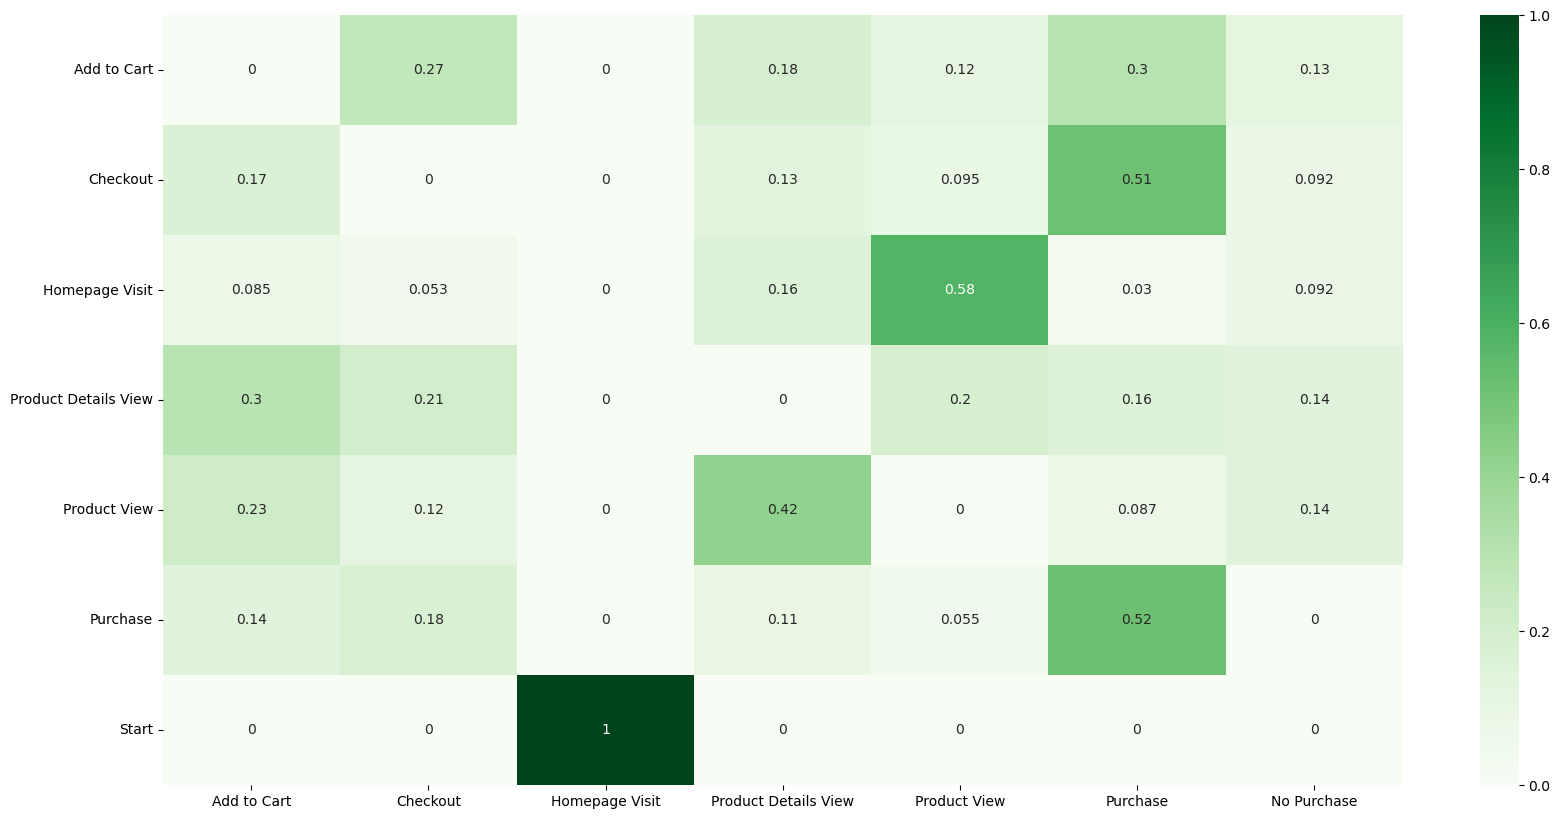

In [114]:
#Create plot figure
plt.figure(figsize=(20,10))

#Create heatmap based on transition probabilities
sns.heatmap(transition_df, annot=True, cmap="Greens")

<Axes: >

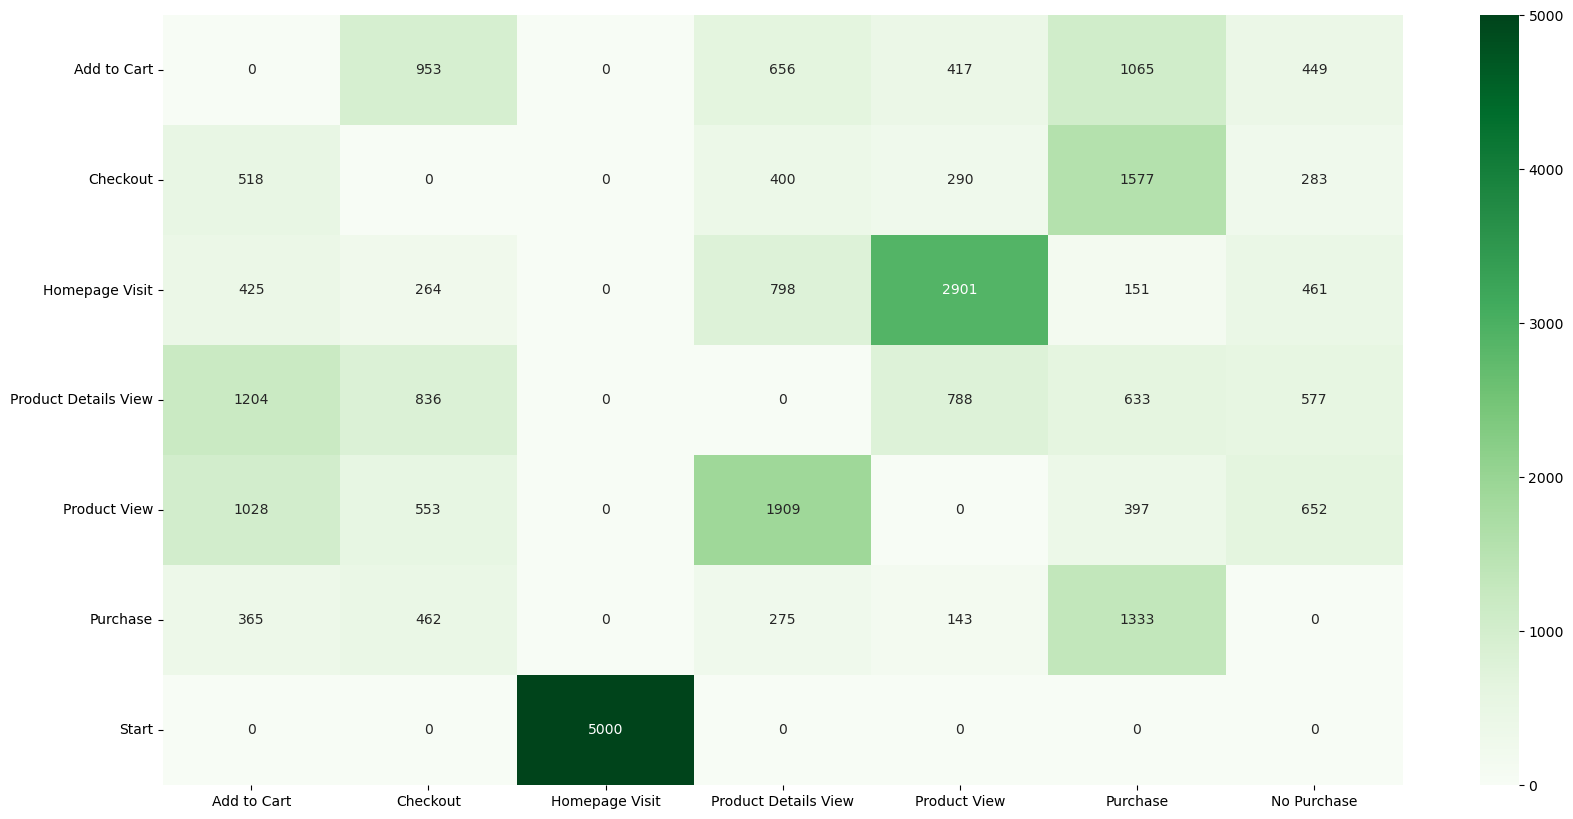

In [115]:
#Create plot figure
plt.figure(figsize=(20,10))

#Create heatmap based on transition values
sns.heatmap(transition_df_counts, annot=True, fmt=".0f", cmap="Greens")

In [116]:
#Identify total number of purchases in dataset
total_purchases = sum(path.count('Purchase') for path in grouped['path'].tolist())

#Create a purchase rate
base_purchase_rate = total_conversions / len(list_of_paths)

print(base_purchase_rate)

0.8


In [117]:
# #Initialize dictionary to hold value of removing specific stage
# removal_effects_dict = {}

# #Iterate through each event in the transition_df_counts dataframe
# for event in transition_df_counts.index:
#     #Skip "Start", "No Purchase" and "Purchase" events
#     if event not in ('Start', 'No Purchase', 'Purchase'):
#         #Create new dataframe to hold values excluding the dropped event
#         new_df = transition_df_counts.drop(event, axis=1).drop(event, axis=0)
#         #Calculate new purchase rate
#         new_conversion = new_df.Purchase.sum() / len(new_df)
#     #Add value to removal_effects dictionary   
#     removal_effects_dict[event] = new_conversion

<Axes: title={'center': 'Purchase Rate based on Dropout Stage'}, xlabel='State Removed from Model', ylabel='Purchase Rate'>

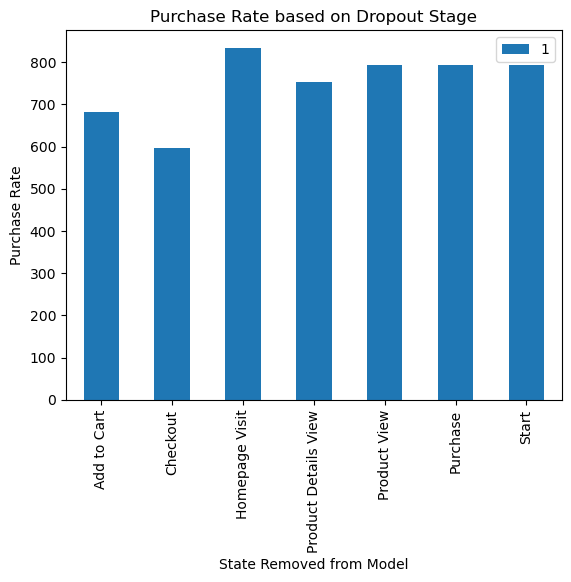

In [118]:
# #Convert items in removal_effects dictionary to a dataframe
# removal_df = pd.DataFrame(removal_effects_dict.items())

# #Create bar chart to visualize change in purchase rate with specific states removed
# removal_df.plot.bar(x=0, y=1, title = "Purchase Rate based on Dropout Stage", ylabel = "Purchase Rate", xlabel = "State Removed from Model")                       